## Analyze A/B Test Results


## Table of Contents
- [Introduction](#intro)
- [Part I - Probability](#probability)
- [Part II - A/B Test](#ab_test)
- [Part III - Regression](#regression)


<a id='intro'></a>
### Introduction

A/B tests are very commonly performed by data analysts and data scientists.  It is important that you get some practice working with the difficulties of these.

<a id='probability'></a>
#### Part I - Probability

To get started, let's import our libraries.

In [2]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
#We are setting the seed to assure you get the same answers on quizzes as we set up
random.seed(42)

`1.` Now, read in the `ab_data.csv` data. Store it in `df`.  **Use your dataframe to answer the questions in Quiz 1 of the classroom.**

a. Read in the dataset and take a look at the top few rows here:

In [3]:
df = pd.read_csv('ab_data.csv')
df.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


b. Use the below cell to find the number of rows in the dataset.

In [4]:
df.shape[0]

294478

c. The number of unique users in the dataset.

In [5]:
df.user_id.nunique()

290584

d. The proportion of users converted.

In [6]:
df.converted.mean()

0.11965919355605512

e. The number of times the `new_page` and `treatment` don't line up.

In [7]:
df.query('group=="treatment" and landing_page!= "new_page"').shape[0] \
+ df.query('group!="treatment" and landing_page== "new_page"').shape[0]

3893

f. Do any of the rows have missing values?

In [8]:
# No Missing Values
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
user_id         294478 non-null int64
timestamp       294478 non-null object
group           294478 non-null object
landing_page    294478 non-null object
converted       294478 non-null int64
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


`2.` For the rows where **treatment** is not aligned with **new_page** or **control** is not aligned with **old_page**, we cannot be sure if this row truly received the new or old page.  Use **Quiz 2** in the classroom to provide how we should handle these rows.  

a. Now use the answer to the quiz to create a new dataset that meets the specifications from the quiz.  Store your new dataframe in **df2**.

In [9]:
df2 = df.drop(df.query('(group=="treatment" and landing_page!="new_page") \
                       or (group!="treatment" and landing_page=="new_page")').index, inplace=False)
df2.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [10]:
# Double Check all of the correct rows were removed - this should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

`3.` Use **df2** and the cells below to answer questions for **Quiz3** in the classroom.

a. How many unique **user_id**s are in **df2**?

In [11]:
df2.user_id.nunique()

290584

b. There is one **user_id** repeated in **df2**.  What is it?

In [12]:
df2[df2.user_id.duplicated()].user_id

2893    773192
Name: user_id, dtype: int64

c. What is the row information for the repeat **user_id**? 

In [13]:
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted
2893,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


d. Remove **one** of the rows with a duplicate **user_id**, but keep your dataframe as **df2**.

In [14]:
df2.drop_duplicates(subset=['user_id'], inplace=True)
df2[df2.user_id.duplicated()]

,user_id,timestamp,group,landing_page,converted


`4.` Use **df2** in the below cells to answer the quiz questions related to **Quiz 4** in the classroom.

a. What is the probability of an individual converting regardless of the page they receive?

In [15]:
df2.converted.mean()

0.11959708724499628

b. Given that an individual was in the `control` group, what is the probability they converted?

In [16]:
df2.query('group=="control"').converted.mean()

0.1203863045004612

c. Given that an individual was in the `treatment` group, what is the probability they converted?

In [17]:
df2.query('group=="treatment"').converted.mean()

0.11880806551510564

d. What is the probability that an individual received the new page?

In [18]:
df2.query('landing_page=="new_page"').shape[0] / df2.shape[0]

0.5000619442226688

In [19]:
df2.query('group=="control"').shape[0], df2.query('group=="treatment"').shape[0]

(145274, 145310)

e. Consider your results from a. through d. above, and explain below whether you think there is sufficient evidence to say that the new treatment page leads to more conversions.

**Answer**
* Converstion rate for treatment group is 11.8% whice is less than control group by 0.16%, with both groups of almost equal sizes.
* Results so for are in favor of the old page. However, further analysis and investigation can be done to figure out whether there are some effects influencing the results (e.g. novelty effect and change aversion). 

<a id='ab_test'></a>
### Part II - A/B Test

Notice that because of the time stamp associated with each event, you could technically run a hypothesis test continuously as each observation was observed.  

However, then the hard question is do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  How long do you run to render a decision that neither page is better than another?  

These questions are the difficult parts associated with A/B tests in general.  


`1.` For now, consider you need to make the decision just based on all the data provided.  If you want to assume that the old page is better unless the new page proves to be definitely better at a Type I error rate of 5%, what should your null and alternative hypotheses be?  You can state your hypothesis in terms of words or in terms of **$p_{old}$** and **$p_{new}$**, which are the converted rates for the old and new pages.

$H_{0}$: $p_{new}$ $-$ $p_{old}$ ${\le}$  $0$

$H_{1}$: $p_{new}$ $-$ $p_{old}$ $>$ $0$

$\alpha$: $5$%

`2.` Assume under the null hypothesis, $p_{new}$ and $p_{old}$ both have "true" success rates equal to the **converted** success rate regardless of page - that is $p_{new}$ and $p_{old}$ are equal. Furthermore, assume they are equal to the **converted** rate in **ab_data.csv** regardless of the page. <br><br>

Use a sample size for each page equal to the ones in **ab_data.csv**.  <br><br>

Perform the sampling distribution for the difference in **converted** between the two pages over 10,000 iterations of calculating an estimate from the null.  <br><br>

Use the cells below to provide the necessary parts of this simulation.  If this doesn't make complete sense right now, don't worry - you are going to work through the problems below to complete this problem.  You can use **Quiz 5** in the classroom to make sure you are on the right track.<br><br>

a. What is the **convert rate** for $p_{new}$ under the null? 

In [20]:
p_new = df2.converted.mean()
p_new

0.11959708724499628

b. What is the **convert rate** for $p_{old}$ under the null? <br><br>

In [21]:
p_old = df2.converted.mean()
p_old

0.11959708724499628

c. What is $n_{new}$?

In [22]:
n_new = df2.query('landing_page=="new_page"').shape[0]
n_new

145310

d. What is $n_{old}$?

In [23]:
n_old = df2.query('landing_page=="old_page"').shape[0]
n_old

145274

e. Simulate $n_{new}$ transactions with a convert rate of $p_{new}$ under the null.  Store these $n_{new}$ 1's and 0's in **new_page_converted**.

In [24]:
new_page_converted = np.random.binomial(1, p=p_new, size=n_new)

f. Simulate $n_{old}$ transactions with a convert rate of $p_{old}$ under the null.  Store these $n_{old}$ 1's and 0's in **old_page_converted**.

In [25]:
old_page_converted = np.random.binomial(1, p=p_old, size=n_old)

g. Find $p_{new}$ - $p_{old}$ for your simulated values from part (e) and (f).

In [26]:
diff = new_page_converted.mean() - old_page_converted.mean()
diff

-0.0008898248774152351

h. Simulate 10,000 $p_{new}$ - $p_{old}$ values using this same process similarly to the one you calculated in parts **a. through g.** above.  Store all 10,000 values in a numpy array called **p_diffs**.

In [52]:
p_diffs = []
for _ in range(10000):
    new_page_converted = np.random.binomial(1, p=p_new, size=n_new)
    old_page_converted = np.random.binomial(1, p=p_old, size=n_old)
    p_diffs.append(new_page_converted.mean() - old_page_converted.mean())
p_diffs = np.array(p_diffs)

i. Plot a histogram of the **p_diffs**.  Does this plot look like what you expected?  Use the matching problem in the classroom to assure you fully understand what was computed here.

-0.0015782389853555567


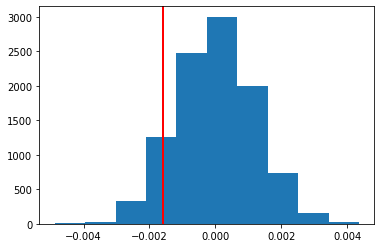

In [53]:
# Yes, it is a normal distribution since it is a sampling distribution for the difference of means according to central limite theorem
actual_diff = df2.query('landing_page=="new_page"').converted.mean() \
                - df2.query('landing_page=="old_page"').converted.mean()
print(actual_diff)
plt.hist(p_diffs)
plt.axvline(x=actual_diff, c='r', linewidth=2);

j. What proportion of the **p_diffs** are greater than the actual difference observed in **ab_data.csv**?

In [54]:
print('p-value: ', (p_diffs > actual_diff).mean())

p-value:  0.9052


In [55]:
((p_diffs - p_diffs.mean()) / p_diffs.std())

array([ 0.59067858,  0.07522061, -0.3181616 , ...,  1.54533793,
        1.08814342, -0.08673828])

k. In words, explain what you just computed in part **j.**  What is this value called in scientific studies?  What does this value mean in terms of whether or not there is a difference between the new and old pages?

**Answer**
* This value, which is 90%, is called p-value.
* It means that if we rejected the null, There is a chance of 90% to make "Type-1" error where the null is true/better but we chose the alternative.
* Since p-value is much larger than $\alpha$ (5%), I think we shouldn't reject the null. In other words, we should stick to the old page.

l. We could also use a built-in to achieve similar results.  Though using the built-in might be easier to code, the above portions are a walkthrough of the ideas that are critical to correctly thinking about statistical significance. Fill in the below to calculate the number of conversions for each page, as well as the number of individuals who received each page. Let `n_old` and `n_new` refer the the number of rows associated with the old page and new pages, respectively.

In [56]:
import statsmodels.api as sm

convert_old = df2.query('landing_page=="old_page"').converted.sum()
convert_new = df2.query('landing_page=="new_page"').converted.sum()
n_old = df2.query('landing_page=="old_page"').shape[0]
n_new = df2.query('landing_page=="new_page"').shape[0]
print('convert_old:', convert_old)
print('convert_new:', convert_new)
print('n_old:', n_old)
print('n_new:', n_new)

convert_old: 17489
convert_new: 17264
n_old: 145274
n_new: 145310


m. Now use `stats.proportions_ztest` to compute your test statistic and p-value.  [Here](http://knowledgetack.com/python/statsmodels/proportions_ztest/) is a helpful link on using the built in.

In [57]:
z_score, p_value = sm.stats.proportions_ztest(count=[convert_old, convert_new], nobs=[n_old, n_new], alternative='smaller')
print('z_score: ', z_score)
print('p-value:', p_value)

z_score:  1.3109241984234394
p-value: 0.9050583127590245


n. What do the z-score and p-value you computed in the previous question mean for the conversion rates of the old and new pages?  Do they agree with the findings in parts **j.** and **k.**?

**Answer**
* p-value is very close to the value we computed above.
* z-score represents how far from the mean a data point is.

<a id='regression'></a>
### Part III - A regression approach

`1.` In this final part, you will see that the result you acheived in the previous A/B test can also be acheived by performing regression.<br><br>

a. Since each row is either a conversion or no conversion, what type of regression should you be performing in this case?

**Answer**
* Logistic Regression since the output is categorical (binary).

b. The goal is to use **statsmodels** to fit the regression model you specified in part **a.** to see if there is a significant difference in conversion based on which page a customer receives.  However, you first need to create a column for the intercept, and create a dummy variable column for which page each user received.  Add an **intercept** column, as well as an **ab_page** column, which is 1 when an individual receives the **treatment** and 0 if **control**.

In [58]:
df2['intercept'] = 1
df2['ab_page'] = pd.get_dummies(df2['group'])['treatment']
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,851104,2017-01-21 22:11:48.556739,control,old_page,0,1,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0,1,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
4,864975,2017-01-21 01:52:26.210827,control,old_page,1,1,0


c. Use **statsmodels** to import your regression model.  Instantiate the model, and fit the model using the two columns you created in part **b.** to predict whether or not an individual converts.

In [59]:
model = sm.Logit(df2['converted'], df2[['intercept', 'ab_page']])
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


d. Provide the summary of your model below, and use it as necessary to answer the following questions.

In [60]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 03 Dec 2020   Pseudo R-squ.:               8.077e-06
Time:                        10:45:33   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""

e. What is the p-value associated with **ab_page**? Why does it differ from the value you found in **Part II**?<br><br>  **Hint**: What are the null and alternative hypotheses associated with your regression model, and how do they compare to the null and alternative hypotheses in the **Part II**?

**Answer**
* p-value is 0.190
* The reason is the hypotheses here are:

$H_{0}$: $p_{new}$ $=$ $p_{old}$  not ($\le$)

$H_{1}$: $p_{new}$ $\ne$ $p_{old}$ not ($>$)

This means that we are dealing with a two-sided test instead of the one-sided test before

f. Now, you are considering other things that might influence whether or not an individual converts.  Discuss why it is a good idea to consider other factors to add into your regression model.  Are there any disadvantages to adding additional terms into your regression model?

**Answer**
* As we said before, There are other effects that may influence the results (e.g. novelty effect and change aversion).
* Including more terms/features may help to understand how the conversion rate changes, for example, considering the countries where the page is loaded.
* Disadvantages exist when adding too many terms because correlated terms may appear.

g. Now along with testing if the conversion rate changes for different pages, also add an effect based on which country a user lives. You will need to read in the **countries.csv** dataset and merge together your datasets on the approporiate rows.  [Here](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.join.html) are the docs for joining tables. 

Does it appear that country had an impact on conversion?  Don't forget to create dummy variables for these country columns - **Hint: You will need two columns for the three dummy variables.** Provide the statistical output as well as a written response to answer this question.

In [61]:
countries_df = pd.read_csv('./countries.csv')
df_new = countries_df.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_new.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page
user_id,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1


In [62]:
df_new = df_new.join(pd.get_dummies(df_new['country']))
df_new.drop(['CA'], axis=1, inplace=True)
df_new.head()
model = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US']])
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366113
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290580
Method:                           MLE   Df Model:                            3
Date:                Thu, 03 Dec 2020   Pseudo R-squ.:               2.323e-05
Time:                        10:45:36   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1760
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0300      0.027    -76.249      0.000      -2.082      -1.978
ab_page       -0.0149      0.011     -1.307      0.191      -0.037       0.007
UK             0.0506      0.028      1.784      0.074      -0.005       0.106
US             0.0408      0.027      1.516      0.130      -0.012       0.093
==============================================================================
"""

* It seems that the country has an effect since its p-value is small, thus it has high signifcance.

h. Though you have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there significant effects on conversion.  Create the necessary additional columns, and fit the new model.  

Provide the summary results, and your conclusions based on the results.

In [63]:
df_new['ab_page_UK_interaction'] = df_new['ab_page'] * df_new['UK']
df_new['ab_page_US_interaction'] = df_new['ab_page'] * df_new['US']
df_new.head()
model = sm.Logit(df_new['converted'], df_new[['intercept', 'ab_page', 'UK', 'US', 'ab_page_UK_interaction', 'ab_page_US_interaction']])
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 03 Dec 2020   Pseudo R-squ.:               3.482e-05
Time:                        10:45:38   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==========================================================================================
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
intercept                 -2.0040      0.036    -55.008      0.000      -2.075      -1.933
ab_page                   -0.0674      0.052     -1.297      0.195      -0.169       0.034
UK                         0.0118      0.040      0.296      0.767      -0.066       0.090
US                         0.0175      0.038      0.465      0.642      -0.056       0.091
ab_page_UK_interaction     0.0783      0.057      1.378      0.168      -0.033       0.190
ab_page_US_interaction     0.0469      0.054      0.872      0.383      -0.059       0.152
==========================================================================================
"""

* Since the p-values for the interactions is pretty small we can assume that they have an effect.
* The interaction columns include the country effects implicitly so the p-values for the countries columns became high which means they are redundent now (correlated with the interaction columns).

## Conclusions
* I think we should keep the old page since there isn't much evidence to reject the null given that $\alpha$ is 5%.
* Considering countries in our calculation helps us to understand how the conversion rate changes.
* Consider adding more features, for example, the device used to load the page (e.g. computer or a mobile).